In [1]:
# Standard Python modules
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
import textwrap

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats

# Import my modules
sys.path.append('../modules') # Path to modules
from constants import ucsd_colors
from plotter import SeabornFig2Grid as sfg
from plotter import range_labels, assign_percentiles, community_heatmap_values, create_heatmap_plot
from preprocess_dataframes import combine_ivt_ar_prec_df, df_annual_clim, calculate_ivt_prec_percentiles, df_AR_annual_clim, df_AR_precip_contribution

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/home/dnash/SEAK_clim_data/' 
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## open precipitation and ivt dfs
## append precip to each community IVT df
option = 'a'
temporal_res = 'daily'
community_lst = ['Hoonah', 'Skagway', 'Klukwan', 'Yakutat', 'Craig', 'Kasaan']

df_lst = combine_ivt_ar_prec_df(option, temporal_res, community_lst) # combine dfs into list of dfs
df_lst[0]

,time,IVT,lat,lon,uIVT,vIVT,IWV,ivtdir,AR,impact,prec,UVdir,extreme
time,,,,,,,,,,,,,
1980-01-01,1980-01-01,148.93,58.00,-135.50,29.62,148.30,11.56,211.02,0,0,6.35,16.50,0
1980-01-02,1980-01-02,147.08,58.00,-135.50,6.58,146.94,11.51,186.81,0,0,10.58,65.70,0
1980-01-03,1980-01-03,101.50,58.00,-135.50,26.70,101.25,10.91,257.80,0,0,20.42,53.43,0
1980-01-04,1980-01-04,29.98,58.00,-135.50,21.53,3.76,5.02,357.52,0,0,NaN,22.56,0
1980-01-05,1980-01-05,207.19,58.00,-135.50,200.70,-24.81,10.29,343.00,1,0,NaN,85.94,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2019-12-27,181.51,58.00,-135.50,83.21,173.45,13.28,236.71,0,1,NaN,168.98,0
2019-12-28,2019-12-28,519.33,58.00,-135.50,173.25,518.97,18.17,222.99,0,0,15.38,127.32,0
2019-12-29,2019-12-29,118.21,58.00,-135.50,43.04,117.63,10.76,208.40,0,0,NaN,112.85,0


In [5]:
## getting bins for heatmaps based on percentiles
perc = [0., 0.10, 0.25, 0.5, 0.75, .95, 1.]
perc_lbl = ['0%', '10%', '25%', '50%', '75%', '95%', '100%']
prec_thres_lst = []
ivt_thres_lst = []
for i, df in enumerate(df_lst):
    sublist = []
    sublist_ivt = []
    for j, (thres, lbl) in enumerate(zip(perc, perc_lbl)):
        sublist.append(df['prec'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
        sublist_ivt.append(df['IVT'].describe(percentiles=[thres]).loc[[lbl]].values.tolist())
    flat_list = [item for l in sublist for item in l] # flatten the list
    flat_list_ivt = [item for l in sublist_ivt for item in l] # flatten the list
    prec_thres_lst.append(flat_list)
    ivt_thres_lst.append(flat_list_ivt)

In [6]:
non_ar_days = []
ar_days = []
ar_extreme = []
non_ar_extreme = []

for i, df in enumerate(df_lst):
    non_ar_days.append(len(df.loc[(df['extreme']== 0) & (df.AR == 0)])) ## non extreme non AR
    ar_days.append(len(df.loc[(df['extreme']== 0) & (df.AR == 1)])) # non extreme AR
    non_ar_extreme.append(len(df.loc[(df['extreme']== 1) & (df.AR == 0)])) # extreme non AR 
    ar_extreme.append(len(df.loc[(df['extreme']== 1) & (df.AR == 1)])) # extreme AR
                    
d = {'Community': community_lst, 'non-AR days': non_ar_days, 'AR days': ar_days, 'Extreme non-AR days': non_ar_extreme, 'Extreme AR days': ar_extreme}
table = pd.DataFrame(data=d)

table

,Community,non-AR days,AR days,Extreme non-AR days,Extreme AR days
0,Hoonah,9670,4644,37,259
1,Skagway,9684,4691,23,212
2,Klukwan,9690,4736,17,167
3,Yakutat,9667,4610,40,293
4,Craig,9668,4651,39,252
5,Kasaan,9639,4688,68,215


## Create panel plot of percentile histogram plots

In [7]:
np.flip(range_labels(perc_lbl))

array(['>95%', '75-95%', '50-75%', '25-50%', '10-25%', '<10%'],
      dtype='<U6')

[32.77027027 36.18940248 43.06025728 53.04465494 71.8512257  87.5       ] [ 1.71232877  4.47080292 13.82803943 38.49945235 74.70910335 93.84404925]
[39.95726496 42.89772727 47.01873935 56.83760684 71.82497332 90.21276596] [ 2.32876712  6.20437956 17.33296824 36.66484118 71.38945927 92.33926129]
[43.32425068 49.27007299 52.67175573 63.14067612 79.2633015  90.76086957] [ 2.73972603  6.56934307 16.31982475 37.02081051 71.66324435 92.6128591 ]
[35.63909774 37.83783784 38.88221154 51.74278846 70.87087087 87.98798799] [ 4.7260274   9.44343066 15.99123768 35.56955093 70.63655031 93.02325581]
[31.20689655 30.92783505 38.40330351 50.06877579 65.26225279 86.59793814] [ 3.35616438  6.66058394 13.14348302 35.24096386 77.24161533 93.57045144]
[29.78723404 35.9246172  37.63288448 50.7082153  60.7079646  75.97173145] [ 3.97260274  6.25       13.52683461 35.78860898 76.07802875 93.57045144]


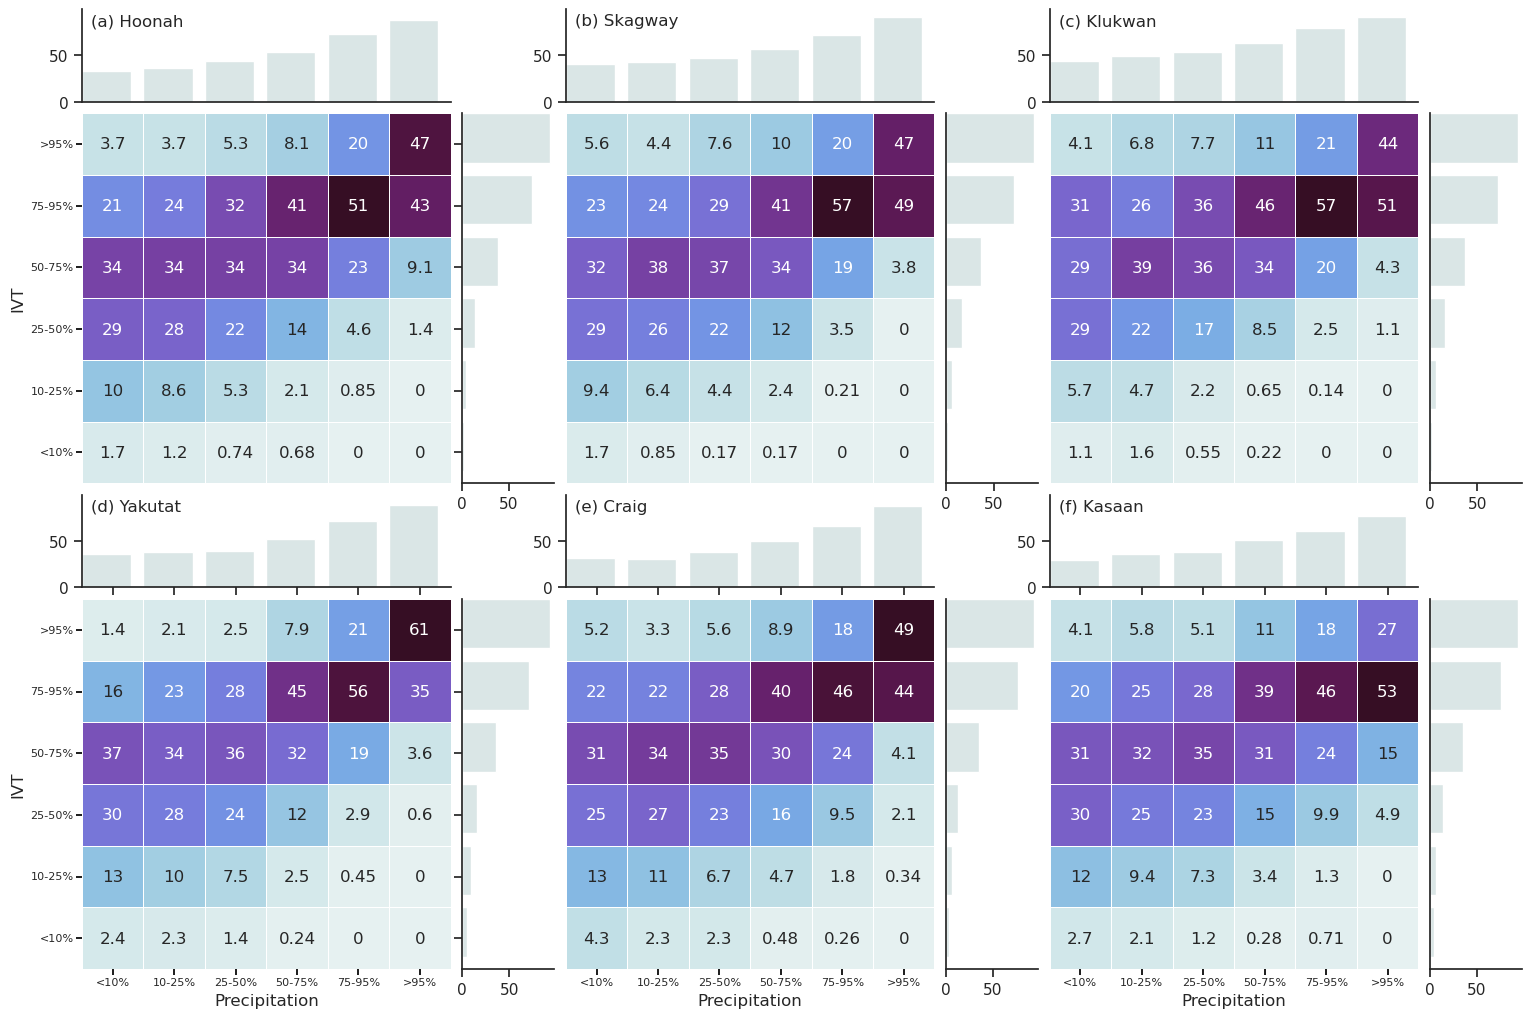

../figs/percentile_bins_daily.png


In [8]:
fname = path_to_figs + 'percentile_bins_{0}'.format(temporal_res)
fmt = 'png'

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

# Start with a square Figure. - then multiple each by the number of rows and columns you want of each full panel
nrows = 2
ncols = 3
# lists of axes locations - I couldn't math this out, but this works
ax_lst = [[1, 0], [1, 2], [1, 4], [3, 0], [3, 2], [3, 4]]
axhistx_lst = [[0, 0], [0, 2], [0, 4], [2, 0], [2, 2], [2, 4]]
axhisty_lst = [[1, 1], [1, 3], [1, 5], [3, 1], [3, 3], [3, 5]]

tcklblx_lst = [False, False, False, range_labels(perc_lbl), range_labels(perc_lbl), range_labels(perc_lbl)]
tcklbly_lst = [np.flip(range_labels(perc_lbl)), False, False, np.flip(range_labels(perc_lbl)), False, False]

xlbl_lst = ['']*3 + ['Precipitation']*3
ylbl_lst = ['IVT', '', '']*2

sns.set_theme(style="ticks")

fig = plt.figure(figsize=(6*ncols, 6*nrows))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2*nrows, 2*ncols,  width_ratios=[4, 1]*ncols, height_ratios=[1, 4]*nrows,
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)


for i, df in enumerate(df_lst):
    # get percentile values
    perc_prec = prec_thres_lst[i]
    perc_ivt = ivt_thres_lst[i]
    # giving each df a column for percentile bins for precip and ivt
    tmp = assign_percentiles(df, prec_thres_lst[i], ivt_thres_lst[i], range_labels(perc_lbl))
    heatmap_vals, extreme_prec_AR, extreme_ivt_AR = community_heatmap_values(tmp, range_labels(perc_lbl))
    print(extreme_prec_AR, extreme_ivt_AR)
    
    # Create the Axes.
    ax = fig.add_subplot(gs[ax_lst[i][0], ax_lst[i][1]])
    ax_histx = fig.add_subplot(gs[axhistx_lst[i][0], axhistx_lst[i][1]], sharex=ax)
    ax_histy = fig.add_subplot(gs[axhisty_lst[i][0], axhisty_lst[i][1]], sharey=ax)

    # plot the heatmap and marginal bar charts
    create_heatmap_plot(heatmap_vals, extreme_prec_AR, extreme_ivt_AR, ax, ax_histx, ax_histy, tcklblx_lst[i], tcklbly_lst[i], range_labels(perc_lbl))
    ax.set_xlabel(xlbl_lst[i])
    ax.set_ylabel(ylbl_lst[i])
    
    # plot title
    titlestring = '({0}) {1}'.format(letter_lst[i], community_lst[i])
    ax_histx.text(0.025, 1.27, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=12., backgroundcolor='white', zorder=101)
    
    ax_histy.invert_yaxis()
    ax.invert_yaxis()
    
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)